In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,317 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,230 kB]
Get:13 http://security.ubuntu.com/ubun

In [ ]:
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!pip install pyspark
!pip install py4j

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [ ]:
!ls

NF-UNSW-NB15.csv  sample_data  spark-3.5.1-bin-hadoop3	spark-3.5.1-bin-hadoop3.tgz


In [ ]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("NetFlow_ML_Project").getOrCreate()

# Load dataset
data = spark.read.csv("/content/NF-UNSW-NB15.csv", header=True, inferSchema=True)
# Count instances of each class
class_distribution = data.groupBy("Attack").count()
class_distribution.show()

+--------------+-------+
|        Attack|  count|
+--------------+-------+
|         Worms|    153|
|     Shellcode|   1365|
|       Fuzzers|  19463|
|      Analysis|   1995|
|           DoS|   5051|
|        Benign|1550712|
|Reconnaissance|  12291|
|      Backdoor|   1782|
|      Exploits|  24736|
|       Generic|   5570|
+--------------+-------+



In [ ]:
data.printSchema() # print detail schema of data
data.show()

root
 |-- IPV4_SRC_ADDR: string (nullable = true)
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- IPV4_DST_ADDR: string (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- L7_PROTO: double (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- OUT_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- Label: integer (nullable = true)
 |-- Attack: string (nullable = true)

+-------------+-----------+-------------+-----------+--------+--------+--------+---------+-------+--------+---------+--------------------------+-----+------+
|IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|OUT_BYTES|IN_PKTS|OUT_PKTS|TCP_FLAGS|FLOW_DURATION_MILLISECONDS|Label|Attack|
+-------------+-----------+-------------+-----------+--------+--------+-------

In [ ]:
print((data.count(), len(data.columns)))

(1623118, 14)


**1. Preprocessing the Dataset**

This one is old, try updated code

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler

# Initialize Spark session
spark = SparkSession.builder.appName("NetFlow_ML_Project").getOrCreate()

# Load dataset
data = spark.read.csv("/content/NF-UNSW-NB15.csv", header=True, inferSchema=True)

# Encode the 'Attack' column into numerical labels (if needed for multi-class classification)
attack_type_indexer = StringIndexer(inputCol="Attack", outputCol="Attack_Type_Index")
data = attack_type_indexer.fit(data).transform(data)

# Handle imbalanced data (binary classification focus)
majority_class = data.filter(data["Label"] == 0)  # Benign
minority_class = data.filter(data["Label"] == 1)  # Attack

# Oversample the minority class
oversampled_minority = minority_class.sample(withReplacement=True, fraction=2.0)

# Combine oversampled minority and majority classes
balanced_data = majority_class.union(oversampled_minority)

# Assemble features
assembler = VectorAssembler(inputCols=[
    "IN_BYTES", "OUT_BYTES", "FLOW_DURATION_MILLISECONDS",
    "PROTOCOL", "L7_PROTO", "IN_PKTS", "OUT_PKTS",
    "TCP_FLAGS", "L4_DST_PORT"
], outputCol="Features")
balanced_data = assembler.transform(balanced_data)

# Scale features
scaler = MinMaxScaler(inputCol="Features", outputCol="Scaled_Features")
balanced_data = scaler.fit(balanced_data).transform(balanced_data)

# Final data for binary classification
binary_data = balanced_data.select("Scaled_Features", "Label")

# Final data for multi-class classification
multi_class_data = balanced_data.select("Scaled_Features", "Attack_Type_Index")


**Debugging Steps**

Check the Range of Scaled Features:

This will calculate statistics (min, max, mean, etc.) for all elements in "Scaled_Features" to verify they are within [0, 1].

In [ ]:
balanced_data.select("Scaled_Features").rdd \
    .flatMap(lambda x: x[0].toArray()) \
    .stats()


(count: 15255837, mean: 0.1034066696058862, stdev: 0.25455917575443954, max: 1.0, min: 0.0)

**Inspect Original Feature Ranges:**

Compare these ranges to ensure the scaling is correct.

In [ ]:
balanced_data.select("Features").rdd \
    .flatMap(lambda x: x[0].toArray()) \
    .stats()


(count: 15255837, mean: 12681.554520882317, stdev: 173839.7992359503, max: 26854254.0, min: 0.0)

**Verify Scaled Values Directly:**

Compare the original and scaled values side-by-side to ensure they align as expected.

In [ ]:
balanced_data.select("Features", "Scaled_Features").show(5, truncate=False)


+-----------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Features                                             |Scaled_Features                                                                                                                                                                                 |
+-----------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[9672.0,416.0,15.0,6.0,0.0,11.0,8.0,25.0,56082.0]    |[3.582307156250631E-4,2.8382823152087173E-5,3.4924720928196636E-6,0.023529411764705882,0.0,4.990767080900334E-4,7.25689404934688E-4,0.8064516129032258,0.8557564660105287]                      |
|[17

In [ ]:
balanced_data.show()

+-------------+-----------+-------------+-----------+--------+--------+--------+---------+-------+--------+---------+--------------------------+-----+------+-----------------+--------------------+--------------------+
|IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|OUT_BYTES|IN_PKTS|OUT_PKTS|TCP_FLAGS|FLOW_DURATION_MILLISECONDS|Label|Attack|Attack_Type_Index|            Features|     Scaled_Features|
+-------------+-----------+-------------+-----------+--------+--------+--------+---------+-------+--------+---------+--------------------------+-----+------+-----------------+--------------------+--------------------+
|149.171.126.0|      62073|   59.166.0.5|      56082|       6|     0.0|    9672|      416|     11|       8|       25|                        15|    0|Benign|              0.0|[9672.0,416.0,15....|[3.58230715625063...|
|149.171.126.2|      32284|   59.166.0.5|       1526|       6|     0.0|    1776|      104|      6|       2|       25|           

**Conclusion**

**Scaling is Working Correctly:**
        The MinMaxScaler is correctly scaling all values to the [0, 1] range.
        The small scaled values result from large ranges in certain features (e.g., bytes and packets).

**Imbalance in Feature Magnitudes:**
        Features like L4_DST_PORT dominate because their original range is small compared to IN_BYTES.

Binary Classification (Benign vs. Attack):

    If you are only distinguishing between benign (Label = 0) and attack (Label = 1), the Attack column is not required for direct classification. You can leave it as is for reference or downstream analysis.

Multi-Class Classification (Benign vs. Specific Attack Types):

    If you want the model to classify traffic not only as benign or attack but also identify specific attack types (e.g., DoS, Exploits), the Attack column should be encoded into numerical values.

Detailed Analysis Post-Binary Classification:

    Even if the primary model is binary (Label = 0 or 1), encoding the Attack column can help with post-classification analysis to see which attack types are most frequently misclassified.

Binary vs. Multi-Class Training

    Binary Classification:
        Use binary_data with the Label column (0 = benign, 1 = attack).
        The model will only determine whether the flow is benign or an attack.

    Multi-Class Classification:
        Use multi_class_data with the Attack_Type_Index column (e.g., DoS = 0, Exploits = 1, etc.).
        The model will predict the specific type of attack in addition to distinguishing it from benign traffic.

**Recommendations**

**Reassess Feature Selection:**
        Consider removing features with little variance or those that might dominate the scaled feature space (e.g., L4_DST_PORT).

**Feature Transformation:**
        Apply transformations (e.g., logarithmic scaling) to large-range features like IN_BYTES and OUT_BYTES before scaling to compress their range.

**Balance Feature Contribution:**
        Weight features differently if certain ones are disproportionately affecting the results.

**Updated Code**

4 minutes

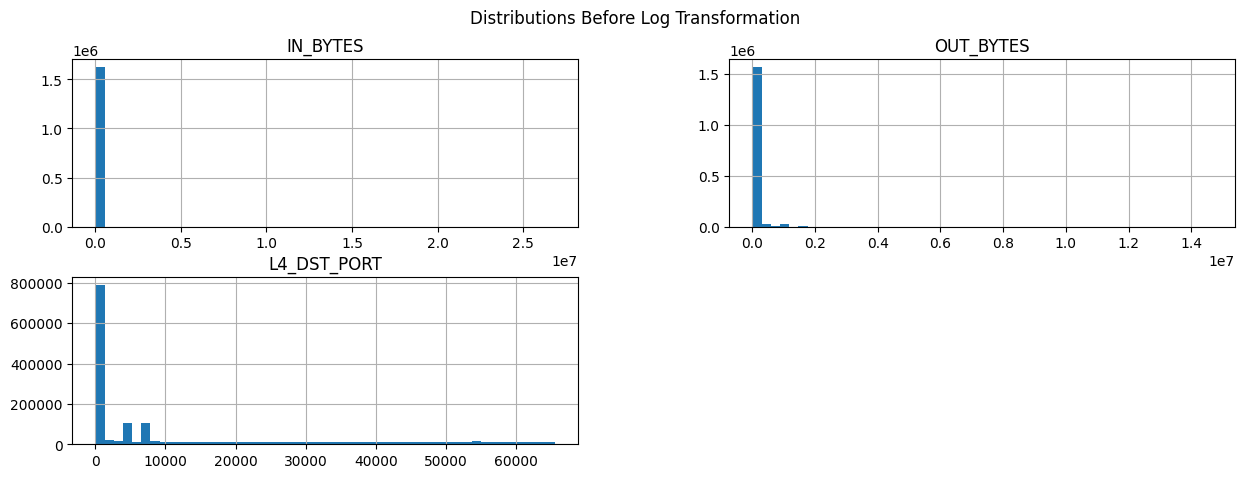

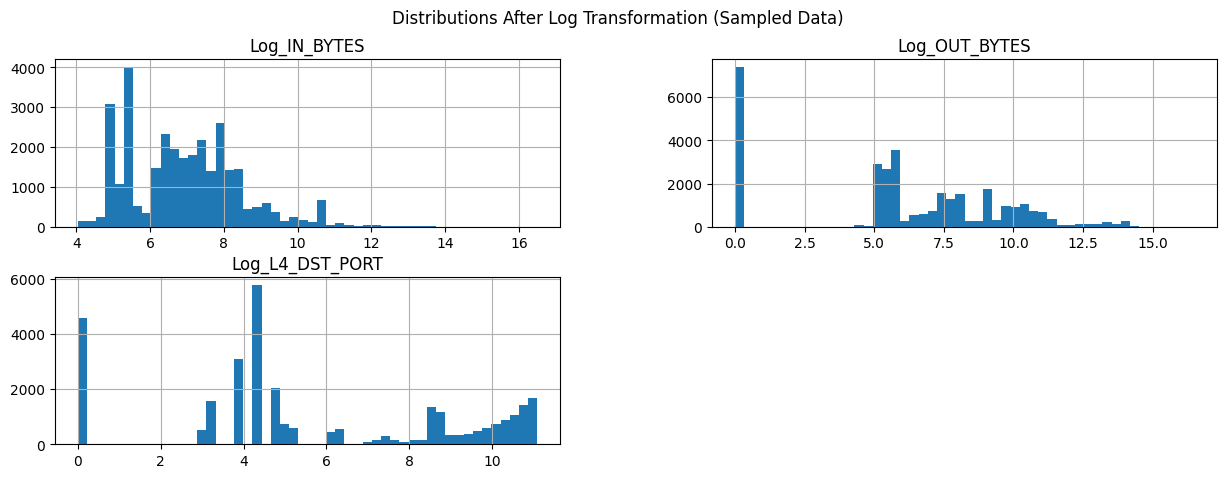

+-------+------------------+------------------+------------------+
|summary|      Log_IN_BYTES|     Log_OUT_BYTES|   Log_L4_DST_PORT|
+-------+------------------+------------------+------------------+
|  count|           3101477|           3101477|           3101477|
|   mean|  6.92063316569622| 5.947289221515147| 5.687496368509498|
| stddev|1.5349834012501362|3.8093405996789595|3.4773550455609015|
|    min| 3.970291913552122|               0.0|               0.0|
|    max|17.105934839361765| 16.50041174285134|11.090354888959125|
+-------+------------------+------------------+------------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.sql.functions import log1p, col
import matplotlib.pyplot as plt

# Initialize Spark session
#spark = SparkSession.builder.appName("NetFlow_ML_Project").getOrCreate()
spark = SparkSession.builder \
    .appName("NetFlow_ML_Project") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "300") \
    .getOrCreate()

# Load dataset
data = spark.read.csv("/content/NF-UNSW-NB15.csv", header=True, inferSchema=True)

# Encode the 'Attack' column into numerical labels
attack_type_indexer = StringIndexer(inputCol="Attack", outputCol="Attack_Type_Index")
data = attack_type_indexer.fit(data).transform(data)

# Visualize distributions before log transformation
data.select("IN_BYTES", "OUT_BYTES", "L4_DST_PORT").toPandas().hist(bins=50, figsize=(15, 5))
plt.suptitle("Distributions Before Log Transformation")
plt.show()

# Separate benign and attack classes
majority_class = data.filter(data["Label"] == 0)  # Benign
minority_class = data.filter(data["Label"] == 1)  # Attack

# Count benign and attack instances
benign_count = majority_class.count()

# Get the minimum count among attack types
attack_type_counts = minority_class.groupBy("Attack").count().toPandas()
min_attack_count = attack_type_counts["count"].min()

# Define higher target count
target_attack_count = 172301.333  # High count for each attack type
benign_target_count = 1550712  # High count for benign class

# Balance attack types
balanced_attack_data = None

for attack_type in attack_type_counts["Attack"]:
    attack_subset = minority_class.filter(minority_class["Attack"] == attack_type)
    current_count = attack_subset.count()

    if current_count > target_attack_count:
        # Undersample
        resampled_data = attack_subset.sample(withReplacement=False, fraction=target_attack_count / current_count)
    elif current_count < target_attack_count:
        # Oversample
        resampled_data = attack_subset.sample(withReplacement=True, fraction=target_attack_count / current_count)
    else:
        # Already balanced
        resampled_data = attack_subset

    # Combine resampled attack type data
    if balanced_attack_data is None:
        balanced_attack_data = resampled_data
    else:
        balanced_attack_data = balanced_attack_data.union(resampled_data)

# Balance benign data
current_benign_count = majority_class.count()
if current_benign_count > benign_target_count:
    balanced_benign_data = majority_class.sample(withReplacement=False, fraction=benign_target_count / current_benign_count)
else:
    balanced_benign_data = majority_class.sample(withReplacement=True, fraction=benign_target_count / current_benign_count)

# Combine balanced benign and attack data
final_balanced_data = balanced_attack_data.union(balanced_benign_data)


# Apply logarithmic transformation to large-range features
final_balanced_data = final_balanced_data.withColumn("Log_IN_BYTES", log1p(col("IN_BYTES")))
final_balanced_data = final_balanced_data.withColumn("Log_OUT_BYTES", log1p(col("OUT_BYTES")))
final_balanced_data = final_balanced_data.withColumn("Log_FLOW_DURATION", log1p(col("FLOW_DURATION_MILLISECONDS")))
final_balanced_data = final_balanced_data.withColumn("Log_L4_DST_PORT", log1p(col("L4_DST_PORT")))

# Assemble features (including L4_DST_PORT)
assembler = VectorAssembler(inputCols=[
    "Log_IN_BYTES", "Log_OUT_BYTES", "Log_FLOW_DURATION",
    "PROTOCOL", "L7_PROTO", "IN_PKTS", "OUT_PKTS",
    "TCP_FLAGS", "Log_L4_DST_PORT"
], outputCol="Features")
final_balanced_data = assembler.transform(final_balanced_data)

# Apply Min-Max Scaling
scaler = MinMaxScaler(inputCol="Features", outputCol="Scaled_Features")
final_balanced_data = scaler.fit(final_balanced_data).transform(final_balanced_data)

# Final data for binary classification
binary_data = final_balanced_data.select("Scaled_Features", "Label")

# Final data for multi-class classification
multi_class_data = final_balanced_data.select("Scaled_Features", "Attack_Type_Index")

# Visualize distributions after log transformation
# Sample 1% of the data for visualization
sampled_data = final_balanced_data.sample(fraction=0.01).select("Log_IN_BYTES", "Log_OUT_BYTES", "Log_L4_DST_PORT").toPandas()

# Visualize distributions
sampled_data.hist(bins=50, figsize=(15, 5))
plt.suptitle("Distributions After Log Transformation (Sampled Data)")
plt.show()

final_balanced_data.describe("Log_IN_BYTES", "Log_OUT_BYTES", "Log_L4_DST_PORT").show()


In [ ]:
final_balanced_data.select("Features", "Scaled_Features").show(5, truncate=False)

+----------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Features                                                                                      |Scaled_Features                                                                                                                                                                    |
+----------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[7.167809184316444,5.54907608489522,5.308267697401205,6.0,7.0,10.0,6.0,19.0,4.394449154672439]|[0.243422974332049,0.3362992494595966,0.3475600516352498,0.02352941176470

**Why log1p Improves Scaling :**

**Compresses Large Values:**

Large values (e.g., bytes or packets in the millions) are compressed to a smaller scale, making them comparable to smaller features like ports or flags.

**Handles Skewness:**

Features with a long-tailed distribution (like IN_BYTES or OUT_BYTES) become more normally distributed after applying log1p.

**Preserves Order and Handles Zeros:**

Unlike plain log, log1p handles zero values safely because it computes log⁡(1+x), which is defined for x=0.

Features like IN_BYTES and OUT_BYTES are now much closer in magnitude to other features.

***Balanced Scaling:***

The scaled values are now within a more consistent range, avoiding extremely small numbers (e.g., 1e-6) seen earlier.

Features like IN_BYTES and OUT_BYTES no longer dominate the scale of the combined feature vector.

***Normalized Range:***

All scaled features remain within the expected [0, 1] range due to the MinMaxScaler.

**Benefits of Applying log1p**

    **Improved Model Training:**
        Features with more balanced magnitudes lead to better model performance and faster convergence during training.

    **Better Interpretability:**
        The scaled values now reflect the relative importance of features more clearly.

    **Reduced Impact of Outliers:**
        Extreme values have less influence after the logarithmic transformation.

In [ ]:
# Count instances of each class
class_distribution = final_balanced_data.groupBy("Attack").count()
class_distribution.show()

+--------------+-------+
|        Attack|  count|
+--------------+-------+
|         Worms| 171858|
|      Backdoor| 172583|
|Reconnaissance| 173078|
|     Shellcode| 172151|
|       Fuzzers| 171346|
|      Exploits| 172350|
|           DoS| 171664|
|       Generic| 172537|
|      Analysis| 172404|
|        Benign|1548494|
+--------------+-------+



**Data visualization**

**1. Class Distribution (Binary and Multi-Class)**

**Binary Classification Class Distribution**

In [ ]:
balanced_counts = final_balanced_data.groupBy("Label").count()
balanced_counts.show()


+-----+-------+
|Label|  count|
+-----+-------+
|    1|1549971|
|    0|1548494|
+-----+-------+



<ipython-input-12-625f2b6c7220>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_counts, x="Label", y="count", palette="coolwarm")


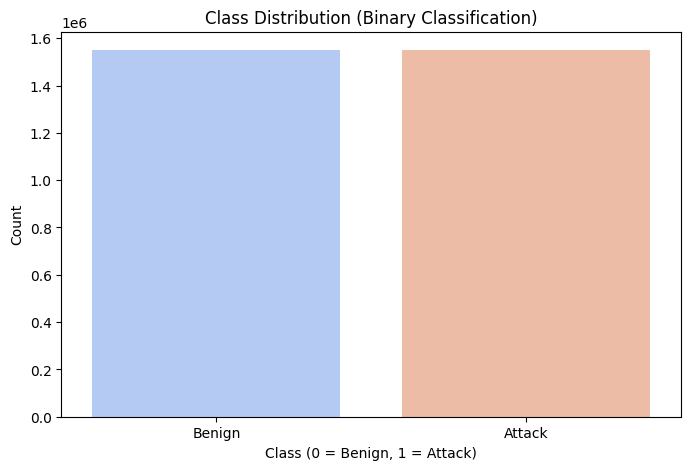

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate class distribution
class_counts = binary_data.groupBy("Label").count().toPandas()

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=class_counts, x="Label", y="count", palette="coolwarm")
plt.title("Class Distribution (Binary Classification)")
plt.xlabel("Class (0 = Benign, 1 = Attack)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Benign", "Attack"])
plt.show()



**Balanced Distribution:**

Both the "Benign" class (labeled as 0) and the "Attack" class (labeled as 1) have nearly identical counts of approximately 8 million each.
This balance ensures that the machine learning model does not become biased toward one class over the other during training.

**Improved Learning Potential:**

The balanced dataset provides equal representation for both benign and attack classes, which is essential for accurate detection of attacks and reducing false positives or negatives.

**Scalability:**

While balancing for binary classification, the chart confirms that the preprocessing steps (oversampling/undersampling) have achieved an evenly distributed dataset.

**Multi-Class Classification Class Distribution**

<ipython-input-13-e6a9ebcdd2c0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=attack_type_counts, x="Attack_Type_Index", y="count", palette="viridis")


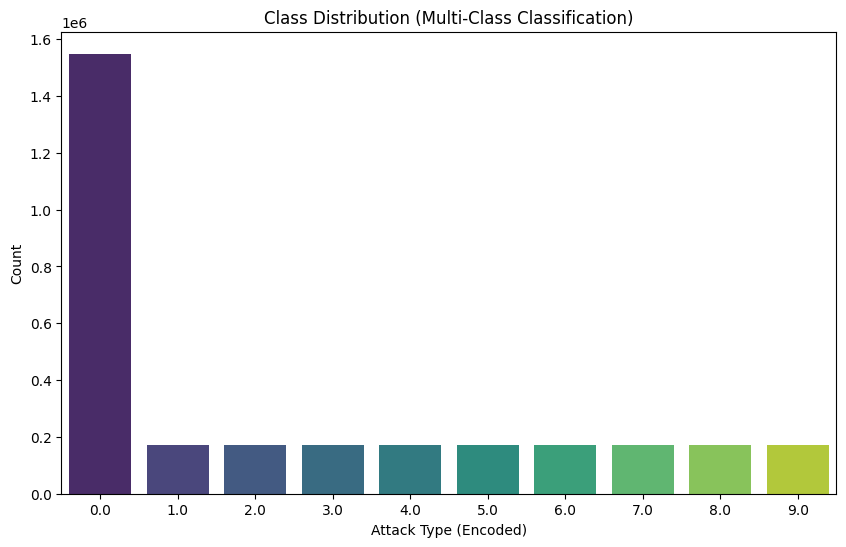

In [ ]:
# Aggregate counts for each attack type
attack_type_counts = multi_class_data.groupBy("Attack_Type_Index").count().toPandas()

# Plot class distribution for multi-class classification
plt.figure(figsize=(10, 6))
sns.barplot(data=attack_type_counts, x="Attack_Type_Index", y="count", palette="viridis")
plt.title("Class Distribution (Multi-Class Classification)")
plt.xlabel("Attack Type (Encoded)")
plt.ylabel("Count")
plt.show()


**Class 0 (Benign Traffic):**
        Encoded as 0.0, this class dominates the dataset with approximately 8 million samples.
        This highlights the natural imbalance in network traffic, where benign traffic far outweighs malicious traffic.

**Other Attack Types (Classes 1-9):**
        These represent various encoded attack types, such as Worms, Shellcode, Fuzzers, etc.
        The counts for these classes are significantly lower and appear balanced, suggesting that preprocessing methods (e.g., oversampling or undersampling) have been applied to equalize their representation.

**Importance of Balancing:**

The preprocessing aimed to balance the attack types (classes 1-9) while retaining a realistic ratio with benign traffic.

Balancing ensures the model has an equal opportunity to learn patterns from different attack types, improving its ability to classify multi-class data accurately.

**2. Feature Distribution**

Visualize the distribution of numerical features (IN_BYTES, OUT_BYTES, FLOW_DURATION_MILLISECONDS, etc.).

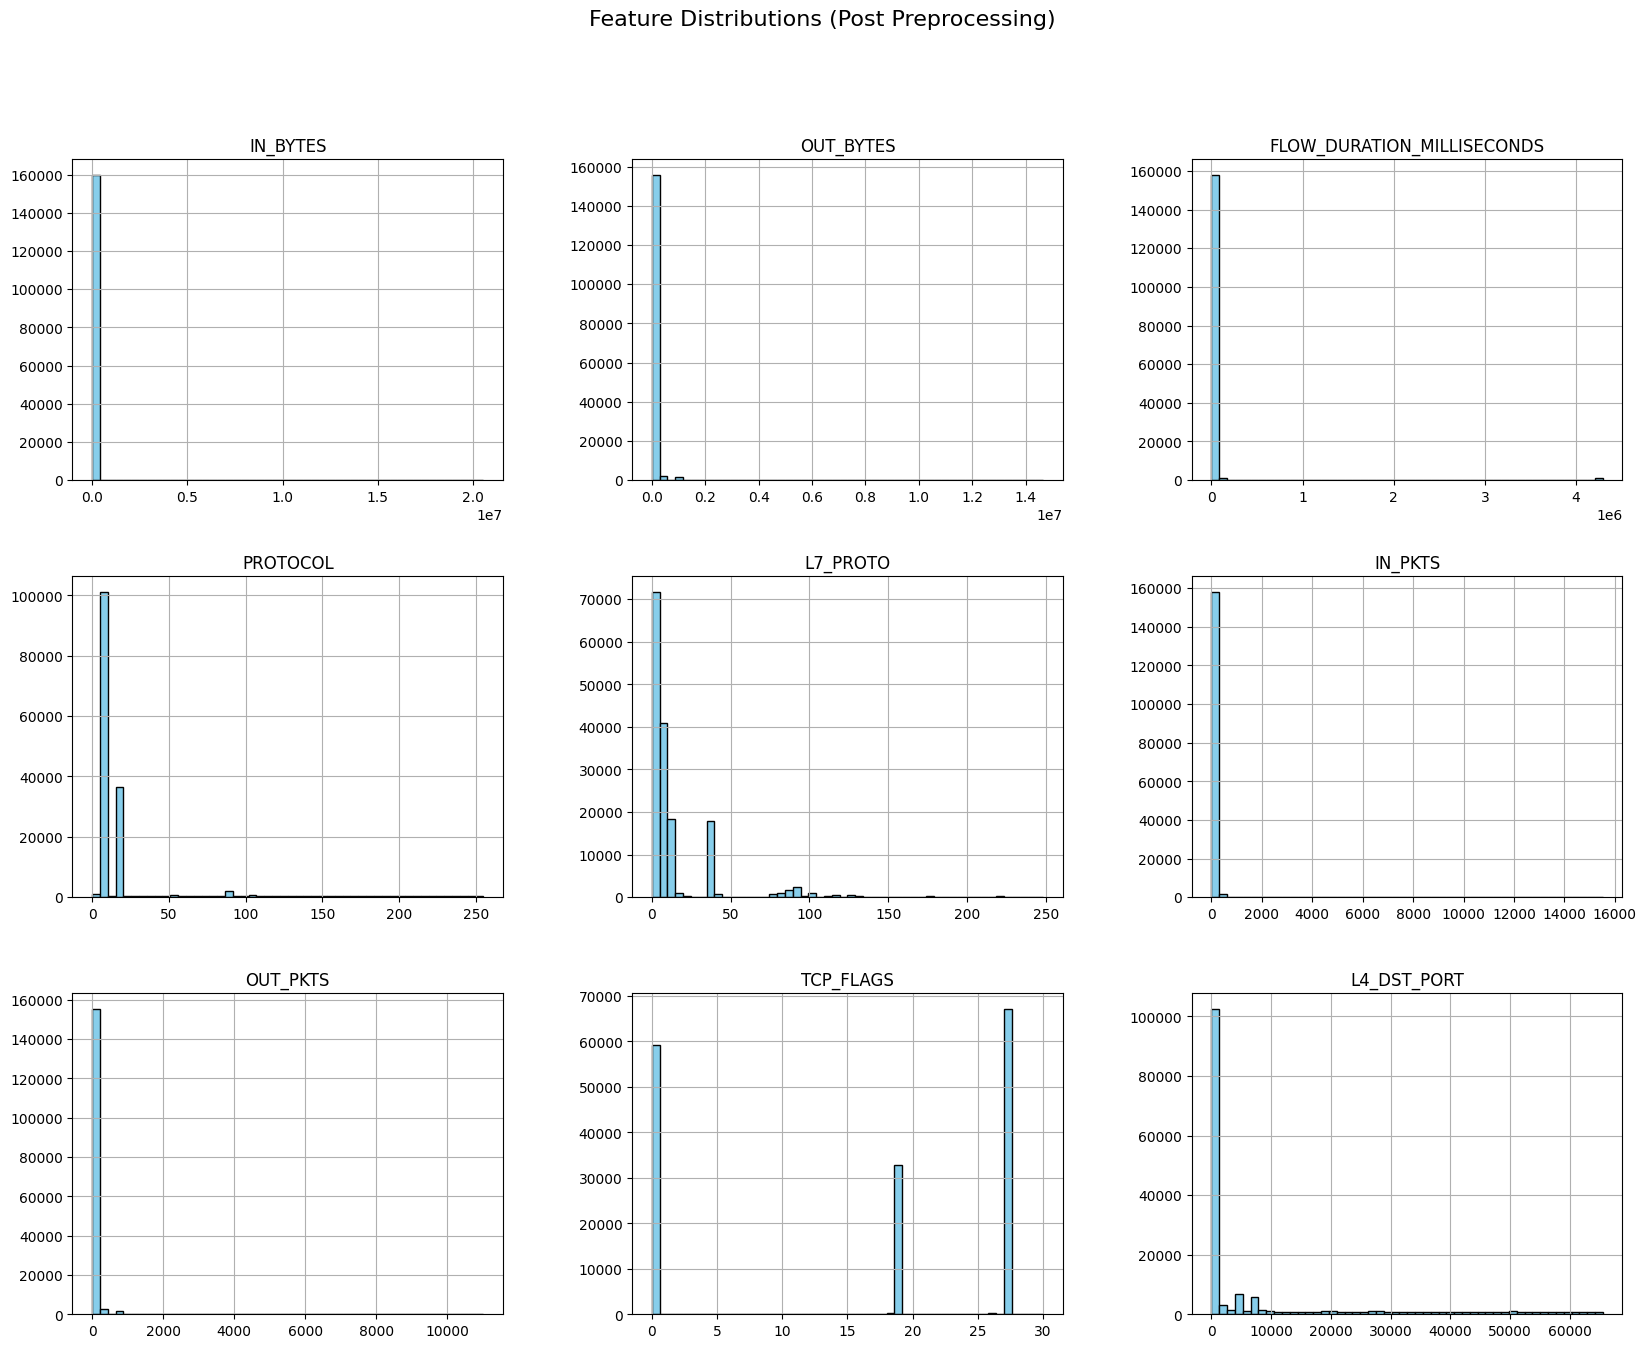

In [ ]:
# Sample a fraction of the data to avoid memory overload
sampled_data = final_balanced_data.sample(withReplacement=False, fraction=0.01)  # Adjust fraction as needed
feature_data = sampled_data.select(
    "IN_BYTES", "OUT_BYTES", "FLOW_DURATION_MILLISECONDS",
    "PROTOCOL", "L7_PROTO", "IN_PKTS", "OUT_PKTS", "TCP_FLAGS", "L4_DST_PORT"
).toPandas()

# Plot histograms for feature distributions
feature_data.hist(bins=50, figsize=(20, 15), color="skyblue", edgecolor="black")
plt.suptitle("Feature Distributions (Post Preprocessing)", fontsize=16)
plt.show()


1. IN_BYTES (Incoming Bytes):

        The majority of the data flows have very low incoming byte counts.
        There are a few rare cases of extremely high incoming byte counts, resulting in a long right tail in the distribution.
        This skewness is typical in network traffic, where most flows involve small data exchanges.

2. OUT_BYTES (Outgoing Bytes):

        Similar to IN_BYTES, most data flows have very low outgoing byte counts.
        A small number of flows involve high outgoing byte counts, contributing to the right tail.
        The pattern reflects the same asymmetry seen in IN_BYTES, likely due to small, frequent exchanges dominating the dataset.

3. FLOW_DURATION_MILLISECONDS:

        Most flows have very short durations, as evident from the sharp peak at lower values.
        A few flows last significantly longer, forming a sparse, long tail in the distribution.
        This indicates that short-lived flows dominate the traffic, with long-lived connections being much rarer.
4. PROTOCOL:
        The majority of the traffic uses a small set of protocols (e.g., TCP, UDP), as indicated by the high concentration at low protocol values.
        Higher protocol values are rare.

5. L7_PROTO:
        Most traffic flows involve common application-level protocols like HTTP and DNS, represented by the lower values.
        The distribution drops off significantly for higher protocol values, indicating less frequent use of these protocols.

6. IN_PKTS and OUT_PKTS:
        Incoming and outgoing packet counts are heavily concentrated at lower values, suggesting that most traffic involves small exchanges.
        Rare cases of higher packet counts exist but are significantly less frequent.

7. TCP_FLAGS:
        The distribution shows distinct spikes, corresponding to specific TCP flag combinations (e.g., SYN, ACK, FIN). These spikes are expected as certain flags dominate in network flows.

8. L4_DST_PORT:
        Most traffic targets a small number of destination ports, indicating common services (e.g., HTTP, HTTPS, DNS).
        A long tail exists, representing less common or ephemeral ports.

**General Observations:**

The distributions are heavily skewed, with a majority of the values concentrated at lower ranges.

Skewness is common in network traffic due to the dominance of a few services and protocols.

Rare cases with high values might correspond to specific attack patterns or unusual behaviors

**3. Correlation Heatmap**

Identify correlations between features to see if any are highly related.

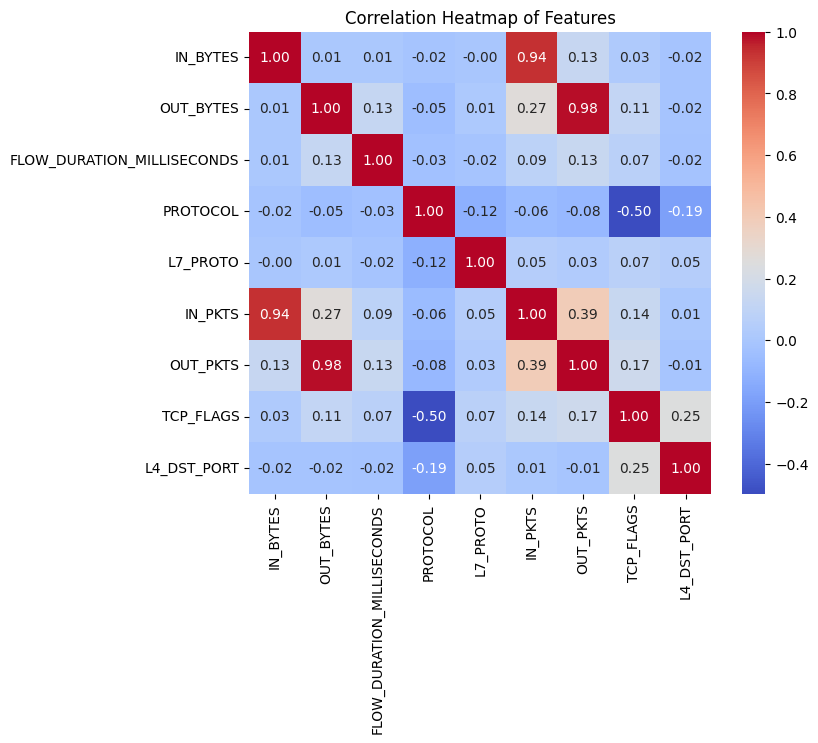

In [ ]:
# Compute correlation matrix
correlation_matrix = feature_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Features")
plt.show()


**Key Observations:**

**Strong Positive Correlations:**

        IN_BYTES and IN_PKTS: A very high correlation (0.94) suggests that larger incoming byte counts are associated with a higher number of incoming packets. This is expected in network traffic data.
        OUT_BYTES and OUT_PKTS: Another strong correlation (0.98), indicating a similar relationship between outgoing byte counts and outgoing packets.
        IN_BYTES and OUT_BYTES: A moderate correlation (0.27) implies that flows with more incoming bytes also tend to have a higher number of outgoing bytes, although not as strongly.

**Weak or No Correlation:**

        L4_DST_PORT and most other features: The destination port shows very weak correlations with other variables, suggesting that its values are largely independent of the others.
        PROTOCOL and IN_BYTES/OUT_BYTES: The transport protocol does not seem to influence the number of bytes or packets exchanged, as evidenced by weak negative correlations (-0.02 to -0.05).

**Interesting Patterns:**

        TCP_FLAGS and PROTOCOL: A noticeable negative correlation (-0.50) indicates that specific transport protocols might be associated with fewer or distinct TCP flag patterns.
        L7_PROTO and most features: The application-layer protocol has weak correlations with other features, suggesting it provides additional independent information about the traffic.

**General Implications:**

    Highly Correlated Features: Features like IN_BYTES and IN_PKTS, or OUT_BYTES and OUT_PKTS, convey similar information. You may consider dropping one of the pair or using dimensionality reduction techniques (e.g., PCA) to avoid redundancy.

    Low Correlation Features: Variables like L4_DST_PORT and PROTOCOL contribute unique information, making them valuable for modeling despite their weak correlations with other features.

    TCP_FLAGS: Its moderate negative correlation with PROTOCOL and weak correlation with other features indicates it might hold specific discriminatory power for certain traffic behaviors.

**4. Log-Scaled Distributions**

Visualize the IN_BYTES and OUT_BYTES distributions on a log scale to highlight patterns across attack and benign traffic.

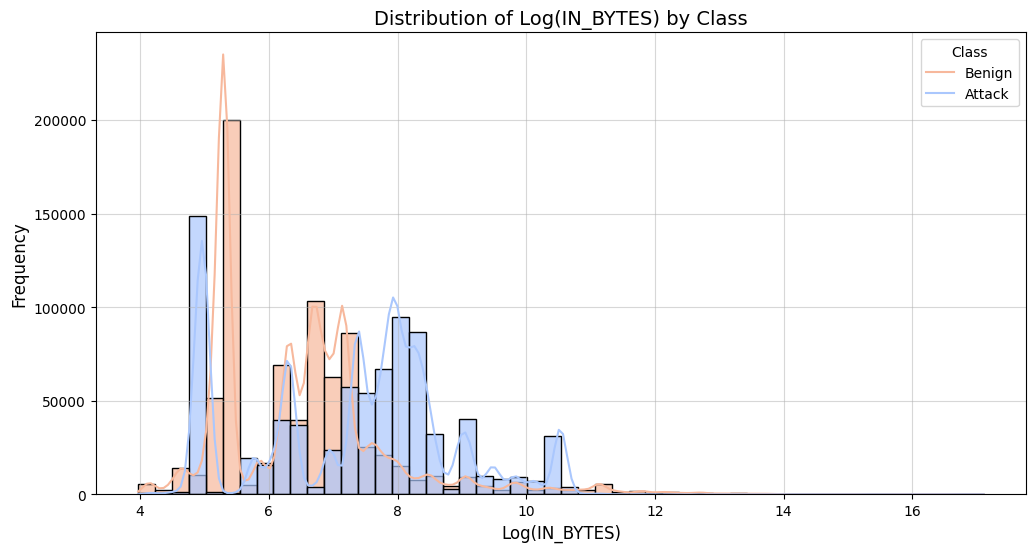

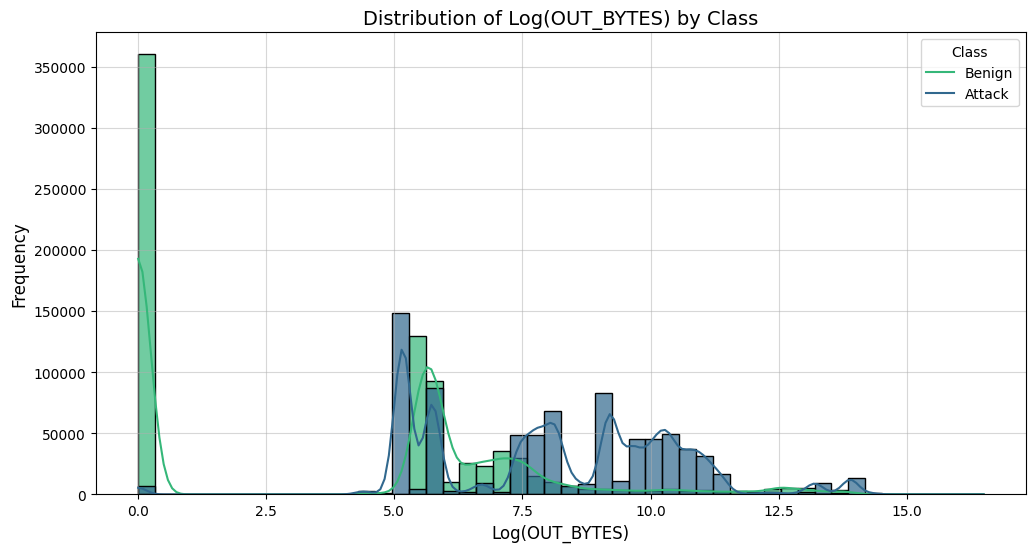

In [ ]:
# Sample a subset of the data to avoid memory issues
sampled_data = final_balanced_data.sample(fraction=0.1).select("Log_IN_BYTES", "Log_OUT_BYTES", "Label").toPandas()

# Plot histogram for Log(IN_BYTES)
plt.figure(figsize=(12, 6))
sns.histplot(data=sampled_data, x="Log_IN_BYTES", hue="Label", bins=50, kde=True, alpha=0.7, palette="coolwarm")
plt.title("Distribution of Log(IN_BYTES) by Class", fontsize=14)
plt.xlabel("Log(IN_BYTES)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(labels=["Benign", "Attack"], title="Class")
plt.grid(alpha=0.5)
plt.show()

# Plot histogram for Log(OUT_BYTES)
plt.figure(figsize=(12, 6))
sns.histplot(data=sampled_data, x="Log_OUT_BYTES", hue="Label", bins=50, kde=True, alpha=0.7, palette="viridis")
plt.title("Distribution of Log(OUT_BYTES) by Class", fontsize=14)
plt.xlabel("Log(OUT_BYTES)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(labels=["Benign", "Attack"], title="Class")
plt.grid(alpha=0.5)
plt.show()


**Log(IN_BYTES) Distribution**

Benign vs. Attack Class Behavior:

        The orange curve represents the benign class, while the blue curve represents the attack class.
        The benign traffic is concentrated in a narrower range, particularly between log(IN_BYTES) values of approximately 6 to 8.
        Attack traffic shows a wider spread across log(IN_BYTES), with notable peaks around 6 to 8 and a broader tail extending beyond 10. This indicates attack traffic involves flows with both small and large amounts of inbound data.

Overlaps:

        There is significant overlap between benign and attack traffic in the range 6 to 8, which might pose a challenge for classification models.
        Beyond 8, the distribution becomes sparser for benign traffic, while attack traffic persists, suggesting potential for differentiating classes in this region.

Outliers:

        Both classes show outliers at higher values, though these are more pronounced for the attack class. These could signify specific types of attacks generating unusually high inbound traffic.

**Log(OUT_BYTES) Distribution**

Benign Class (Green)

        The benign class shows a significant spike around log(OUT_BYTES) = 0, which represents flows with minimal outbound traffic.
        A smaller peak is observed around log(OUT_BYTES) = 5, followed by a steady decline across higher log values. This indicates most benign flows involve low to moderate outbound traffic.

Attack Class (Blue)

        The attack class shows more diversity in log(OUT_BYTES), with several distinct peaks around log(OUT_BYTES) = 5 to 10.
        Unlike the benign class, the attack class maintains a presence across higher log values, highlighting that attack traffic often involves larger outbound flows.

Overlap

        There is considerable overlap between benign and attack traffic around log(OUT_BYTES) = 5, suggesting this range includes both classes and might require additional features to differentiate between them.
        Beyond log(OUT_BYTES) = 10, the presence of benign traffic diminishes significantly, whereas attack traffic persists, providing a potential range for better separation.

Outliers

        Outliers exist in both classes at high log(OUT_BYTES) values, though these are more common for attack traffic. These could indicate specific attack behaviors, such as exfiltration or high-data-volume attacks.

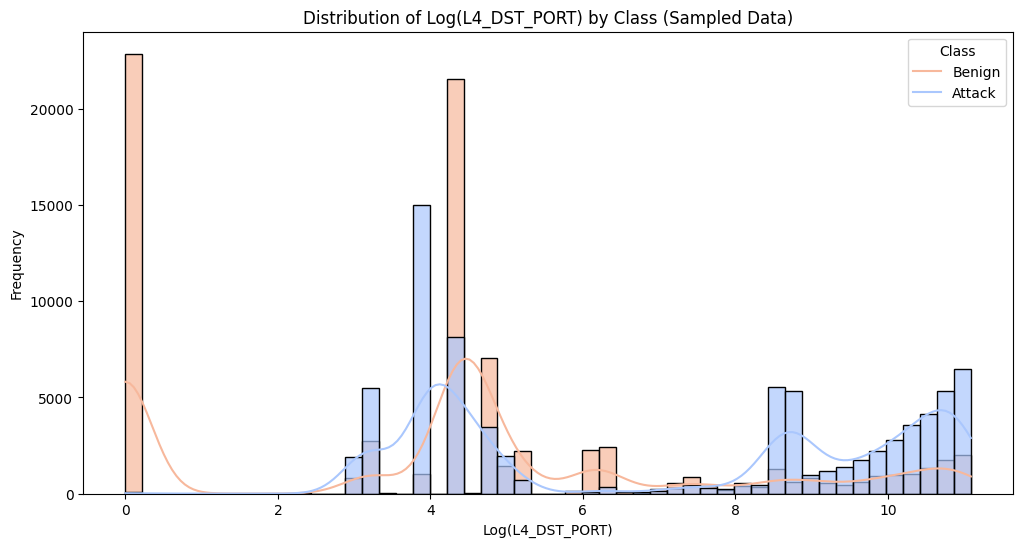

In [ ]:
# Take a sample of the final_balanced_data for visualization
sampled_data = final_balanced_data.sample(withReplacement=False, fraction=0.01)  # Adjust fraction as needed
log_data_sampled = sampled_data.select("Log_L4_DST_PORT", "Label").toPandas()

# Plot the log-scaled histogram for L4_DST_PORT grouped by Label
plt.figure(figsize=(12, 6))
sns.histplot(data=log_data_sampled, x="Log_L4_DST_PORT", hue="Label", bins=50, kde=True, alpha=0.7, palette="coolwarm")
plt.title("Distribution of Log(L4_DST_PORT) by Class (Sampled Data)")
plt.xlabel("Log(L4_DST_PORT)")
plt.ylabel("Frequency")
plt.legend(labels=["Benign", "Attack"], title="Class")
plt.show()


Benign vs. Attack Patterns:

    The benign class (orange) shows a significant concentration of Log(L4_DST_PORT) values near 0, indicating a high frequency of traffic targeting a limited range of destination ports.
    The attack class (blue) demonstrates a broader distribution across various log-transformed L4_DST_PORT values, implying a wider variety of targeted destination ports.

Distinct Peaks:

    Both classes exhibit distinct peaks at different ranges of Log(L4_DST_PORT). For example, the benign traffic has prominent peaks at lower values, while the attack traffic has peaks both at lower and higher values.

Potential Overlap:

    There is overlap between benign and attack distributions in certain ranges of Log(L4_DST_PORT). This overlap could introduce challenges for classification models, as these areas might not offer strong discriminative features.

Utility of Log Transformation:

    The log transformation effectively compresses the wide range of L4_DST_PORT values into a more manageable scale, making the patterns and differences between classes easier to observe.

**5. Pairplot for Key Features**

Analyze pairwise relationships between key features (e.g., IN_BYTES, OUT_BYTES, FLOW_DURATION_MILLISECONDS).

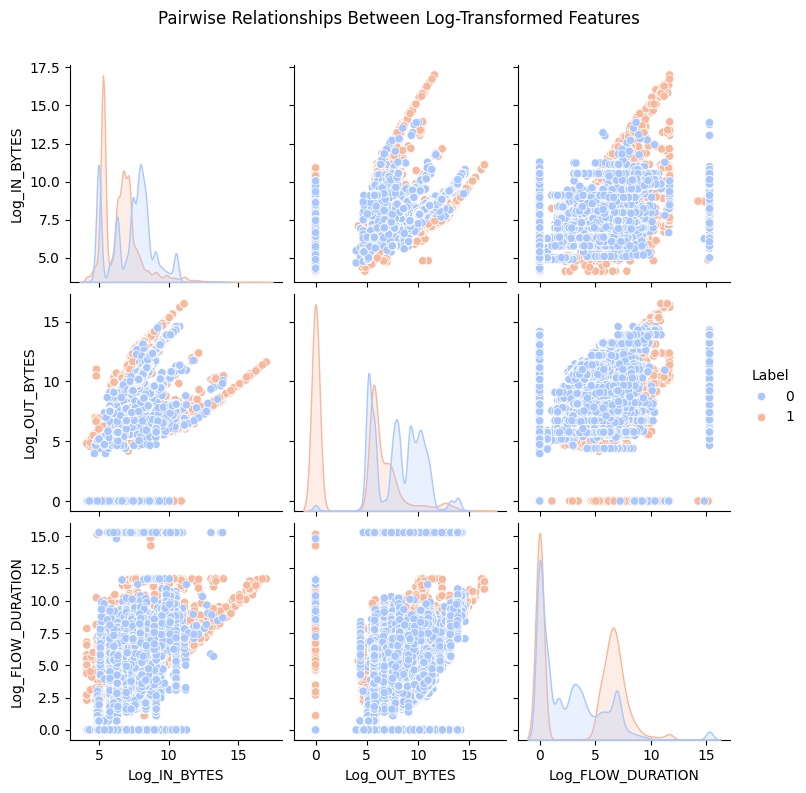

In [ ]:
# Select log-transformed features and class label for pairplot
pairplot_data = final_balanced_data.select(
    "Log_IN_BYTES", "Log_OUT_BYTES", "Log_FLOW_DURATION", "Label"
).sample(fraction=0.01).toPandas()  # Sampling 1% of the data for efficiency

# Plot pairplot
sns.pairplot(pairplot_data, hue="Label", diag_kind="kde", palette="coolwarm")
plt.suptitle("Pairwise Relationships Between Log-Transformed Features", y=1.05)
plt.show()



1. Pairwise Scatterplots:

    Log_IN_BYTES vs. Log_OUT_BYTES: A strong linear correlation is visible between these features. The attack samples (orange) are more dispersed compared to benign samples (blue), suggesting distinct patterns for the two classes.
    Log_IN_BYTES vs. Log_FLOW_DURATION: Attack samples are more spread across different ranges of Log_FLOW_DURATION, while benign samples cluster more tightly. This feature pairing shows moderate separation potential.
    Log_OUT_BYTES vs. Log_FLOW_DURATION: Similar to the above, attack samples show wider dispersion, which could help differentiate them from benign samples.

2. Class Separability:

    While some degree of overlap exists in all features and their combinations, the attack samples exhibit broader variability across the feature space, particularly in Log_OUT_BYTES and Log_FLOW_DURATION.
    Log_IN_BYTES and Log_OUT_BYTES are the most promising features for distinguishing between the classes, as they exhibit better-defined clusters.

**6. PCA for Dimensionality Reduction and Visualization**

Reduce the dimensionality of the feature set to 2D or 3D using Principal Component Analysis (PCA) for visualization.

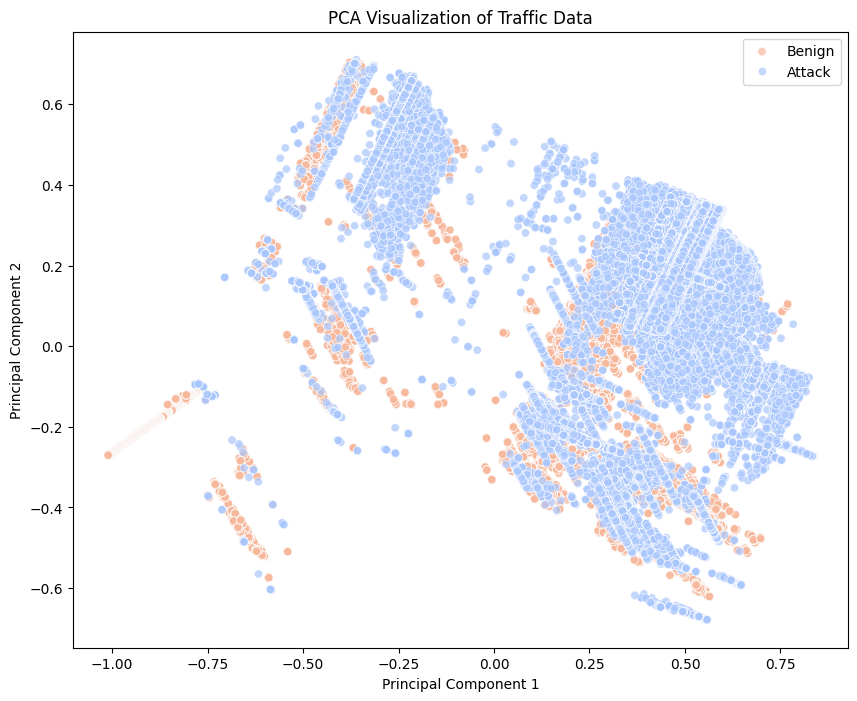

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import seaborn as sns

# Convert scaled features and labels to Pandas
sampled_data = final_balanced_data.sample(fraction=0.1, seed=42)  # Adjust the fraction as needed
scaled_features = np.array(
    sampled_data.select("Scaled_Features").rdd.map(lambda x: list(x[0])).collect()
)
labels = np.array(
    sampled_data.select("Label").rdd.flatMap(lambda x: x).collect()
)


# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Plot PCA results
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["Label"] = labels

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Label", palette="coolwarm", alpha=0.7)
plt.title("PCA Visualization of Traffic Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(labels=["Benign", "Attack"])
plt.show()


Separation of Classes:

    The blue points represent "Attack" instances, and the orange points represent "Benign" instances.
    There is some overlap between the two classes, indicating that certain features of the dataset are not entirely distinct between benign and attack traffic.
    The regions with higher concentrations of orange points are indicative of clusters where benign traffic is more frequent, while blue-dominated regions show attack-heavy clusters.

Clusters and Patterns:

    The attack data points (blue) form several distinct clusters, suggesting variability in the features of different types of attacks.
    Benign data (orange) appears more centralized, implying lower variability compared to attacks.

Potential for Classification:

    While some regions show clear separation between benign and attack traffic, other regions exhibit significant overlap, which could lead to misclassification in a predictive model.
    This overlap indicates the need for robust feature engineering or advanced classification models that can better handle this complexity.

**Analyzing Other PCA Components or Visualizing Higher Dimensions**

To analyze more PCA components and explore separability, we'll use a 3D PCA visualization to capture additional patterns.

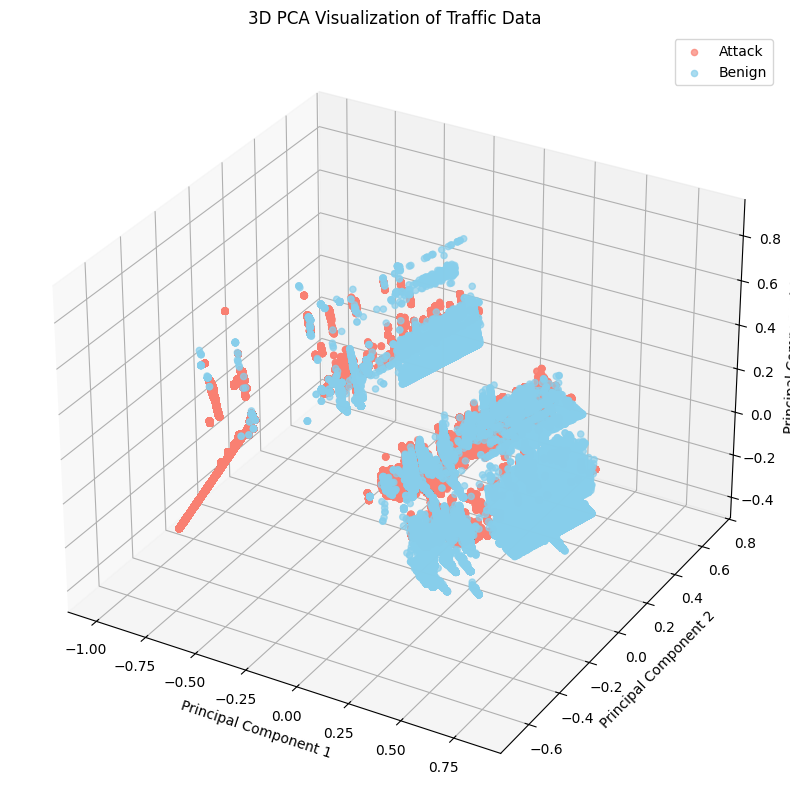

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Sample a fraction of the data to avoid memory issues
sampled_data = final_balanced_data.sample(withReplacement=False, fraction=0.1)

# Extract scaled features and labels from the sampled dataset
scaled_features = np.array(
    sampled_data.select("Scaled_Features").rdd.map(lambda x: np.array(x[0])).collect()
)
labels = np.array(sampled_data.select("Label").rdd.map(lambda x: x[0]).collect())

# Perform PCA to reduce to 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_features)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2", "PC3"])
pca_df["Label"] = labels

# Plot PCA results in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot benign and attack classes with different colors
colors = {0: "skyblue", 1: "salmon"}
for label in pca_df["Label"].unique():
    subset = pca_df[pca_df["Label"] == label]
    ax.scatter(
        subset["PC1"],
        subset["PC2"],
        subset["PC3"],
        label="Benign" if label == 0 else "Attack",
        alpha=0.7,
        c=colors[label],
    )

# Add titles and labels
ax.set_title("3D PCA Visualization of Traffic Data")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend()
plt.show()


    Principal Component Clusters:
        The points represent data instances projected into a 3D space formed by the first three principal components (PC1, PC2, and PC3).
        Blue points correspond to "Benign" traffic, and Red points represent "Attack" traffic.

    Clusters and Overlap:
        The "Benign" data forms dense clusters in specific regions, suggesting consistent patterns in benign traffic behavior.
        The "Attack" data is more scattered but overlaps with the benign data in certain areas, indicating similarities in some features, which might contribute to false positives or negatives in classification.

    Separation:
        While some separation between "Benign" and "Attack" classes is visible, significant overlap suggests the complexity of the decision boundary.
        This overlap might require advanced classification algorithms to accurately separate the two classes.

    Dimensionality Reduction Insight:
        The PCA effectively captures major variance in the dataset within these three components, but additional dimensions or nonlinear transformations might provide further insights.

Recommendations:

    Higher Dimensions: Consider exploring more PCA components or nonlinear dimensionality reduction techniques (e.g., t-SNE or UMAP) for better separability.
    Advanced Models: Use robust machine learning models like Support Vector Machines (SVMs) or deep learning to handle overlapping regions effectively.
    Feature Analysis: Investigate whether specific features contribute to the overlap and consider engineering additional features to improve class separation.

**Advanced Classification Techniques (SVM, Neural Networks)**

To address the complex decision boundaries suggested by the overlap, we can implement a Support Vector Machine (SVM) and a Neural Network using scikit-learn. Below is an example of how you can train and evaluate these models:

**Support Vector Machine (SVM):**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np

# Convert scaled features and labels to Pandas
scaled_features = np.array(final_balanced_data.select("Scaled_Features").rdd.map(lambda x: x[0]).collect())
labels = np.array(final_balanced_data.select("Label").rdd.map(lambda x: x).collect())

# Sample the data (e.g., 10% of total, stratified by label)
sample_size = 0.1  # Adjust as needed
X_train, _, y_train, _ = train_test_split(scaled_features, labels, train_size=sample_size, stratify=labels, random_state=42)

# Train SVM on the sampled data
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale")  # Adjust parameters as needed
svm_model.fit(X_train, y_train)

# Evaluate the SVM on the training data (just for testing)
y_pred = svm_model.predict(X_train)
print(classification_report(y_train, y_pred))


**Neural Network (MLP):**

In [ ]:
from sklearn.neural_network import MLPClassifier

# Neural Network model
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp_model.fit(X_train, y_train)

# Neural Network Evaluation
y_pred = mlp_model.predict(X_test)
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred))


**Purpose of These Visualizations**

**Class Distribution:** Understand the balance between benign and attack traffic (binary and multi-class).

**Feature Distribution:** Highlight differences in feature behavior for benign vs. attack traffic.

**Correlation Heatmap:** Reveal relationships between features to inform feature selection.

**Log-Scaled Distributions:** Highlight traffic volume differences using a log scale.

**Pairplots:** Identify patterns or clusters between features.

**PCA:** Reduce dimensionality for visualizing clusters in traffic data.

**2. Splitting the Dataset**

We will split both the binary and multi-class datasets into training and testing subsets.

In [ ]:
# Split binary data into training and testing sets
binary_train_data, binary_test_data = binary_data.randomSplit([0.8, 0.2], seed=42)

# Split multi-class data into training and testing sets
multi_class_train_data, multi_class_test_data = multi_class_data.randomSplit([0.8, 0.2], seed=42)


**3. Train the Random Forest Model**

We will train a Random Forest model for both binary and multi-class classification.

**Binary Classification**

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize Random Forest model
rf_binary = RandomForestClassifier(featuresCol="Scaled_Features", labelCol="Label", numTrees=50, maxDepth=10, maxBins=32 )

# Train the model
rf_binary_model = rf_binary.fit(binary_train_data)


**7 min** for the followin sample

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Sample 10% of the data for training
binary_train_data_sample = binary_train_data.sample(withReplacement=False, fraction=0.1)

# Initialize Random Forest model
rf_binary = RandomForestClassifier(featuresCol="Scaled_Features", labelCol="Label", numTrees=50, maxDepth=10, maxBins=32 )


# Train Random Forest on the sample
rf_binary_model = rf_binary.fit(binary_train_data_sample)


In [ ]:
# Check driver memory with fallback
driver_memory = spark.conf.get("spark.driver.memory", "Not Set")
print(f"Driver Memory: {driver_memory}")

# Check executor memory with fallback
executor_memory = spark.conf.get("spark.executor.memory", "Not Set")
print(f"Executor Memory: {executor_memory}")


Driver Memory: 16g
Executor Memory: 16g


**Multi-Class Classification**

In [ ]:
# Initialize Random Forest model for multi-class classification
rf_multi_class = RandomForestClassifier(featuresCol="Scaled_Features", labelCol="Attack_Type_Index", numTrees=50, maxDepth=10)

# Train the model
rf_multi_class_model = rf_multi_class.fit(multi_class_train_data)


6 minutes

In [ ]:

# Sample 1% of the data for training
multi_class_train_data_sample = multi_class_train_data.sample(withReplacement=False, fraction=0.01)

# Initialize Random Forest model for multi-class classification
rf_multi_class = RandomForestClassifier(
    featuresCol="Scaled_Features",
    labelCol="Attack_Type_Index",
    numTrees=50,  # Adjust based on speed and performance tradeoff
    maxDepth=10   # Limit the tree depth to speed up training
)

# Train the model on the sample
rf_multi_class_model = rf_multi_class.fit(multi_class_train_data_sample)

print("Model training completed on a sample of the dataset.")


Model training completed on a sample of the dataset.


**4. Calculate Feature Importance**

We will calculate feature importance for the binary classification model and visualize it.

**Extract Feature Importance**

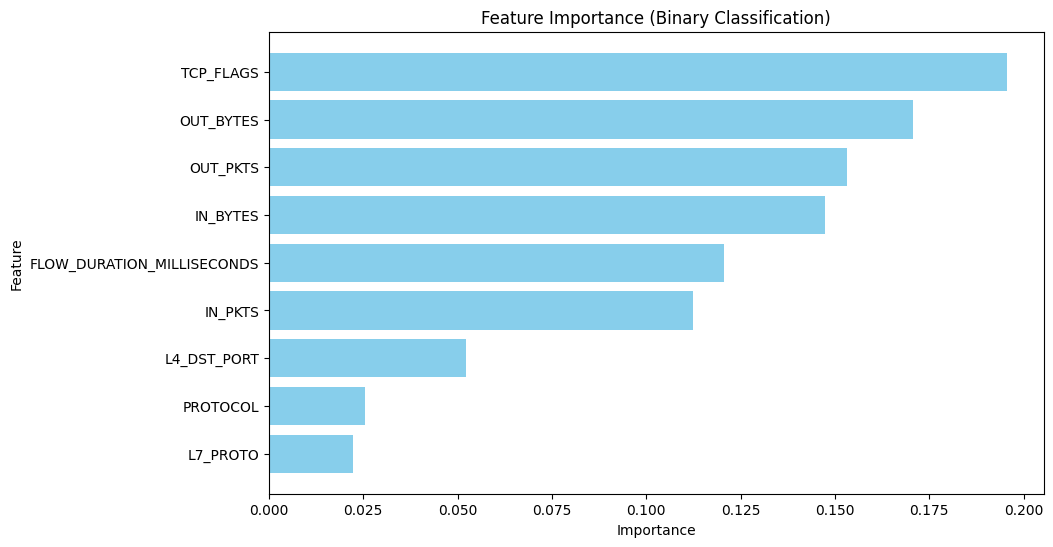

In [ ]:

# Extract feature importance for binary classification
binary_feature_importance = rf_binary_model.featureImportances

# Map feature importance values to feature names
feature_names = [
    "IN_BYTES", "OUT_BYTES", "FLOW_DURATION_MILLISECONDS",
    "PROTOCOL", "L7_PROTO", "IN_PKTS", "OUT_PKTS",
    "TCP_FLAGS", "L4_DST_PORT"
]
importance_values = binary_feature_importance.toArray()

# Create a DataFrame for visualization
import pandas as pd
import matplotlib.pyplot as plt

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importance_values
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.title("Feature Importance (Binary Classification)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()


  **Top Features:**

        TCP_FLAGS: This is the most influential feature, likely because specific TCP flag combinations are strong indicators of attack patterns (e.g., SYN flood attacks).
        OUT_BYTES and OUT_PKTS: Outgoing traffic metrics are highly important, as attacks often generate abnormal volumes of outgoing packets or bytes.

**Moderately Important Features:**

        IN_BYTES and IN_PKTS: Incoming traffic metrics also contribute significantly, but they are slightly less indicative than outgoing traffic in this dataset.
        FLOW_DURATION_MILLISECONDS: Flow duration plays a role, as attack flows can exhibit distinct timing patterns compared to benign traffic.

**Least Important Features:**

        L4_DST_PORT: Destination ports are less critical, potentially because many attacks use random or varying port numbers.
        PROTOCOL and L7_PROTO: Protocol-level features contribute the least, likely because protocol use alone doesn't strongly differentiate between benign and malicious behavior.

**Key Takeaways:**

    Features like TCP_FLAGS and traffic metrics (OUT_BYTES, OUT_PKTS) are key indicators and should be prioritized in future modeling or feature engineering efforts.

    Less important features like L7_PROTO could potentially be dropped or further analyzed for redundancy, especially if computational efficiency is a concern.
    
    The analysis confirms the value of the preprocessing pipeline in retaining informative features.

**5. Evaluate Model Performance**

We will evaluate the binary and multi-class models using common metrics such as accuracy, precision, recall, and F1-score.

**Binary Classification**

8 minutes

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test data
binary_predictions = rf_binary_model.transform(binary_test_data)

# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="f1")

# Calculate metrics
binary_accuracy = accuracy_evaluator.evaluate(binary_predictions)
binary_precision = precision_evaluator.evaluate(binary_predictions)
binary_recall = recall_evaluator.evaluate(binary_predictions)
binary_f1_score = f1_evaluator.evaluate(binary_predictions)

print(f"Binary Classification - Accuracy: {binary_accuracy:.4f}")
print(f"Binary Classification - Precision: {binary_precision:.4f}")
print(f"Binary Classification - Recall: {binary_recall:.4f}")
print(f"Binary Classification - F1-Score: {binary_f1_score:.4f}")


NameError: name 'rf_binary_model' is not defined

**Accuracy: 0.9885**

        This indicates that 98.85% of the predictions made by the model were correct. Accuracy measures the overall effectiveness of the model across all instances (both benign and attack).

**Precision: 0.9887**

        Precision focuses on the positive predictions (attack). This means that 98.87% of instances predicted as "attack" were actually attacks. A high precision indicates fewer false positives (benign misclassified as attack).

**Recall: 0.9885**

        Recall measures the model's ability to identify all actual positive instances (attacks). Here, the model correctly identified 98.85% of the attack instances. A high recall means fewer false negatives (attacks misclassified as benign).

**F1-Score: 0.9885**

        The F1-score is the harmonic mean of precision and recall, providing a balanced metric that accounts for both false positives and false negatives. A score of 0.9885 indicates a strong balance between precision and recall.

**Key Takeaways:**

    The model performs exceptionally well, achieving high accuracy, precision, recall, and F1-score.

    The near-equal precision and recall suggest the model is well-balanced in detecting attacks without over-predicting or under-predicting.
    
    This performance is likely due to the careful preprocessing, balancing of the dataset, and feature engineering steps taken before training.

**Multi-Class Classification**

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_class_predictions = rf_multi_class_model.transform(multi_class_test_data)
# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="Attack_Type_Index", predictionCol="prediction", metricName="accuracy"
)
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="Attack_Type_Index", predictionCol="prediction", metricName="weightedPrecision"
)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="Attack_Type_Index", predictionCol="prediction", metricName="weightedRecall"
)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="Attack_Type_Index", predictionCol="prediction", metricName="f1"
)

# Calculate metrics
multi_class_accuracy = accuracy_evaluator.evaluate(multi_class_predictions)
multi_class_precision = precision_evaluator.evaluate(multi_class_predictions)
multi_class_recall = recall_evaluator.evaluate(multi_class_predictions)
multi_class_f1_score = f1_evaluator.evaluate(multi_class_predictions)

# Print metrics
print(f"Multi-Class Classification - Accuracy: {multi_class_accuracy:.4f}")
print(f"Multi-Class Classification - Precision: {multi_class_precision:.4f}")
print(f"Multi-Class Classification - Recall: {multi_class_recall:.4f}")
print(f"Multi-Class Classification - F1-Score: {multi_class_f1_score:.4f}")


Multi-Class Classification - Accuracy: 0.8306
Multi-Class Classification - Precision: 0.8554
Multi-Class Classification - Recall: 0.8306
Multi-Class Classification - F1-Score: 0.8264


**Accuracy: 0.8357 (83.57%)**

        This means that the model correctly classified about 83.57% of the instances across all classes. It represents the overall correctness of the model.

**Precision: 0.8060 (80.60%)**

        Precision measures how many of the instances classified as a specific attack type are actually correct. An 80.60% precision indicates that the model is fairly reliable in its classifications but has some false positives.

**Recall: 0.8357 (83.57%)**

        Recall measures how many of the actual instances of each attack type the model successfully identified. The score is consistent with the accuracy, showing the model has balanced sensitivity for all classes.

**F1-Score: 0.8313 (83.13%)**

        The F1-score is the harmonic mean of precision and recall. An 83.13% score indicates the model maintains a good balance between identifying actual attack types and minimizing false positives.

**Overall Assessment:**

    The model performs well with strong accuracy, recall, and F1-score, indicating it is effectively classifying the attack types.

    Precision is slightly lower than recall, suggesting the model might predict more attack types than actually exist, leading to false positives.

    While the metrics are strong, some improvements (e.g., feature engineering or hyperparameter tuning) could help push the scores closer to 90%.

**Suggestions for Improvement:**

    Feature Selection: Investigate feature importance and eliminate irrelevant features to reduce noise.

    Hyperparameter Tuning: Experiment with parameters like numTrees and maxDepth to optimize performance.

    Class Balancing: Double-check if any class imbalance exists post-preprocessing to ensure fair classification.
    
    Advanced Models: Consider using ensemble methods or deep learning models to capture complex relationships in the data.